<a href="https://colab.research.google.com/github/acmilannesta/Bert-embedding/blob/master/CDC/CDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

--2019-10-17 18:28:17--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 2a00:1450:400c:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  97.6MB/s    in 4.2s    

2019-10-17 18:28:22 (91.8 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [0]:
!git clone https://github.com/acmilannesta/Bert-embedding

Cloning into 'Bert-embedding'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 67 (delta 29), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [0]:
!pip install keras_bert

  Created wheel for keras-bert: filename=keras_bert-0.80.0-cp36-none-any.whl size=37923 sha256=295549ac7378a58577b2107dca6378cc9c99867e087af4eb561a1420238a71cf
  Stored in directory: /root/.cache/pip/wheels/63/dc/87/3260cb91f3aa32c0f85c5375429a30c8fd988bbb48f5ee21b0
  Created wheel for keras-transformer: filename=keras_transformer-0.31.0-cp36-none-any.whl size=13385 sha256=2376b401fe275bf32c72acc716396e9a38e57a4eab08102e40259a97a8d7ecb8
  Stored in directory: /root/.cache/pip/wheels/a3/c5/9a/5a5130240be614a7a6fa786765d7692ae97f82601e2161bb56
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7553 sha256=331ddd366dc6c4c200a33f76e6d27a0bb560da006e84ce4809374a1403b58b40
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=8aac22658f9ae5dc743a7b5669c6da3f7927f3d72a6a6a5aaf1b98a40e3f6391
  Stor

In [0]:
import json
import numpy as np
import pandas as pd
from random import choice
from keras_bert import load_trained_model_from_checkpoint, Tokenizer, AdamWarmup, calc_train_steps
import re, os, gc
import codecs
from keras.layers import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [0]:
MAXLEN = 142 #@param {type:'slider', min:50, max:300, step:1}
BATCH_SIZE = 16 #@param {type:'slider', min:8, max:32, step:8}
config_path = 'uncased_L-12_H-768_A-12/bert_config.json' #@param ['uncased_L-12_H-768_A-12/bert_config.json', 'drive/My Drive/biobert_pretrain_output_all_notes_150000/bert_config.json']
checkpoint_path = 'uncased_L-12_H-768_A-12/bert_model.ckpt' #@param ['uncased_L-12_H-768_A-12/bert_model.ckpt', '/drive/My Drive/biobert_pretrain_output_all_notes_150000/model.ckpt']
dict_path = 'uncased_L-12_H-768_A-12/vocab.txt' #@param ['uncased_L-12_H-768_A-12/vocab.txt', 'drive/My Drive/biobert_pretrain_output_all_notes_150000/vocab.txt']

In [0]:
token_dict = {}
with codecs.open(dict_path, 'r', 'utf8') as reader:
  for line in reader:
      token = line.strip()
      token_dict[token] = len(token_dict)

In [0]:
# class OurTokenizer(Tokenizer):
#     def _tokenize(self, text):
#         R = []
#         for c in text:
#             if c in self._token_dict:
#                 R.append(c)
#             # elif self._is_space(c):
#             #     R.append('[unused1]')
#             else:
#                 R.append('[UNK]')
#         return R

tokenizer = Tokenizer(token_dict)

In [0]:
train = pd.read_csv('Bert-embedding/CDC/train.csv')
test = pd.read_csv('Bert-embedding/CDC/test.csv')
wt = pd.DataFrame(train.event.value_counts()/len(train)).rename(columns={'event':'weight'})
wt['event'] = wt.index
train = train.merge(wt, how='left', on='event')
train['event_idx'] = train.event.map({y:x for x, y in enumerate(np.sort(train.event.unique()))})
# X_train, X_val, y_train, y_val = train_test_split(train[['text', 'weight']], train['event'], test_size=0.2, random_state=0)
# train_data = list(zip(X_train['text'], X_train['weight'], y_train))
# valid_data = list(zip(X_val['text'], X_val['weight'], y_val))

In [0]:
train['text_grouped'] = train.groupby('event')['text'].transform(lambda x: ' '.join(x))

In [0]:
x = train[['event', 'text_grouped', 'weight']].drop_duplicates('event').sort_values('weight', ascending=False)

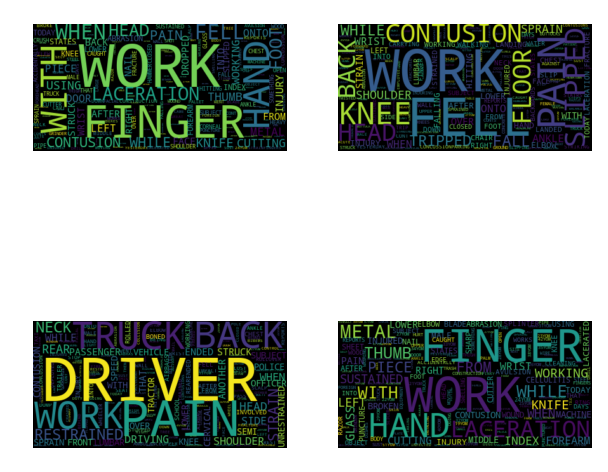

In [94]:
# from itertools import groupby 
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
f, ax = plt.subplots(2, 2, figsize=(10, 10))
for seq in range(4):
  string = x.loc[seq, 'text_grouped'].split(' ')
  counts = [(len(list(c)),i) for i,c in groupby(sorted(string)) if len(i)>3]      # Create value-count pairs as list of tuples 
  counts_dict = {x[1]:x[0] for x in counts}

  wordcloud = WordCloud(margin=0, collocations=False).generate_from_frequencies(counts_dict)
  
  ax[seq//2, seq%2].imshow(wordcloud, interpolation='bilinear')
  ax[seq//2, seq%2].set_title('event:'+str(x.loc[seq, 'event']), fontsize=16, color='white')
  ax[seq//2, seq%2].set_axis_off()
  ax[seq//2, seq%2].margins(x=0, y=0)
  # plt.savefig('e:\\wordcloud_shanghai.jpg')


In [87]:
5//2

2

In [0]:
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df['text'][i], max_len=142)
        indices.append(ids)
        targets.append(data_df['event_idx'][i])
    items = list(zip(indices, targets))
    np.random.shuffle(items)
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

In [0]:
train_x, train_y = convert_data(train)

100%|██████████| 153956/153956 [00:42<00:00, 3634.14it/s]


In [0]:
# def seq_padding(X, padding=0):
#   L = [len(x) for x in X]
#   ML = max(L)
#   return np.array([np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X])

# class data_generator:
#   def __init__(self, data, batch_size=BATCH_SIZE, maxlen=MAXLEN):
#     self.data = data
#     self.batch_size = batch_size
#     self.maxlen = maxlen
#     self.steps = len(self.data) // self.batch_size
#     if len(self.data) % self.batch_size != 0:
#         self.steps += 1
#   def __len__(self):
#     return self.steps
#   def __iter__(self):
#     while True:
#       idxs = list(range(len(self.data)))
#       np.random.shuffle(idxs)
#       X1, X2, W, Y = [], [], [], []
#       for i in idxs:
#         d = self.data[i]
#         text = d[0][:self.maxlen]
#         x1, x2 = tokenizer.encode(first=text)
#         w = d[1]
#         y = d[2]
#         X1.append(x1)
#         X2.append(x2)
#         W.append(w)
#         Y.append([y])
#         if len(X1) == self.batch_size or i == idxs[-1]:
#           X1 = seq_padding(X1)
#           X2 = seq_padding(X2)
#           Y = seq_padding(Y)
#           yield [X1, X2, np.array(W)], Y
#           [X1, X2, W, Y] = [], [], [], []

In [0]:
bert_model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    seq_len = MAXLEN,
    trainable=True)

# x1_in = Input(shape=(None,))
# x2_in = Input(shape=(None,))
# w_in = Input(shape=(1,))
inputs = bert_model.inputs[:2]
dense = bert_model.layers[-3].output
# x = bert_model([x1_in, x2_in])
# x = Lambda(lambda x: x[:, 0])(x)
outputs = Dense(48, activation='softmax')(dense)
model = Model(inputs, outputs)

# model = Model([x1_in, x2_in], p)
# def f1(weights):
#     def metric(true_labels, predictions):
#         f1 = tf.contrib.metrics.f1_score(true_labels, predictions, weights=weights)[1]
#         K.get_session().run(tf.local_variables_initializer())
#         return f1
#     return metric
# decay_steps, warmup_steps = calc_train_steps(
#     len(train_data),
#     batch_size=BATCH_SIZE,
#     epochs=2,
# )
loss = "sparse_categorical_crossentropy" #@param ['sparse_categorical_crossentropy', 'categroical_crossentropy']
metrics = "sparse_categorical_accuracy" #@param ['sparse_categorical_accuracy', 'acc']
model.compile(
    loss=loss,
    optimizer=SGD(lr=1e-4), #Adam(1e-5),
    # optimizer=AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, lr=1e-5),
    metrics= [metrics]
)


In [0]:
model.fit(train_x, train_y, batch_size=16, epochs=2, validation_split=0.2)

ValueError: ignored

In [0]:
pred = model.predict([x[500:600] for x in train_x])

In [0]:
pred

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [0]:
train_D = data_generator(train_data[:500])
valid_D = data_generator(valid_data[:500])
model.fit_generator(
    train_D.__iter__(),
    steps_per_epoch=len(train_D),
    epochs=2,
    validation_data=valid_D.__iter__(),
    validation_steps=len(valid_D)
)

Epoch 1/2
32/32 [==============================] - 24s 751ms/step - loss: nan - sparse_categorical_accuracy: 0.0000e+00 - val_loss: nan - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/2
32/32 [==============================] - 21s 661ms/step - loss: nan - sparse_categorical_accuracy: 0.0000e+00 - val_loss: nan - val_sparse_categorical_accuracy: 0.0000e+00


142

In [0]:
pred = model.predict_generator(valid_D.__iter__(), len(valid_D))

In [0]:
pred

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [0]:
print('ROC-AUC: {:.2f}%'.format(roc_auc_score([x[1] for x in valid_data], pred)*100))
print('Accuracy Score: {:.2f}%'.format(accuracy_score([x[1] for x in valid_data], [int(x>0.5) for x in pred])*100))
print('Precision Score: {:.2f}%'.format(precision_score([x[1] for x in valid_data], [int(x>0.5) for x in pred])*100))
print('Recall Score: {:.2f}%'.format(recall_score([x[1] for x in valid_data], [int(x>0.5) for x in pred])*100))
print('F1 Score: {:.2f}%'.format(f1_score([x[1] for x in valid_data], [int(x>0.5) for x in pred])*100))